### Covid-19 Fake or Fact Analysis with NLP Classifiers
> During the COVID-19 pandamic, social media saw a significant increase in the spread of false information. It caused undue harm including fatalities around the world. Machine Learning Models using Natural Language Processing (NLP) provide a mechanism to validate information during such emergencies, which could save lives.

> The project uses NLP Classifiers: Linear Regression, Decision Tree and Multinomial NB to classify Covid-19 news as fake or real. It uses the kaggle dataset: https://www.kaggle.com/datasets/elvinagammed/covid19-fake-news-dataset-nlp for model training and evaluation.

> The dataset consists of 9600 messages from various social media platforms namely: Twitter, Facebook, Instagram etc.


#### Import necessary libraries

In [3]:
import warnings
warnings.filterwarnings("ignore")

In [4]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import mean_squared_error
from sklearn.metrics import accuracy_score, confusion_matrix

In [5]:
import nltk
from nltk.stem import PorterStemmer, WordNetLemmatizer
from nltk import word_tokenize
from nltk import TweetTokenizer
import time

In [6]:
#nltk.download('wordnet')
#nltk.download('omw-1.4')
#nltk.download('punkt')
#nltk.download('stopwords')

In [7]:
from nltk.corpus import stopwords
from wordcloud import WordCloud, STOPWORDS

#### Read training, test data. Drop duplicates and null values

In [9]:
df_train = pd.read_csv('data/train.csv', on_bad_lines='warn').drop_duplicates().dropna()
df_test = pd.read_csv('data/test.csv').drop_duplicates().dropna()

### EDA
> #### Sample few messages

In [11]:
df_train.head()

,id,tweet,label
0,1,The CDC currently reports 99031 deaths. In gen...,real
1,2,States reported 1121 deaths a small rise from ...,real
2,3,Politically Correct Woman (Almost) Uses Pandem...,fake
3,4,#IndiaFightsCorona: We have 1524 #COVID testin...,real
4,5,Populous states can generate large case counts...,real


In [12]:
df_test.head()

,id,tweet,label
0,1,Chinese converting to Islam after realising th...,fake
1,2,11 out of 13 people (from the Diamond Princess...,fake
2,3,"COVID-19 Is Caused By A Bacterium, Not Virus A...",fake
3,4,Mike Pence in RNC speech praises Donald Trump’...,fake
4,5,6/10 Sky's @EdConwaySky explains the latest #C...,real


#### Findings: 
> Need to remove punctuation, hashtags, usernames and numbers

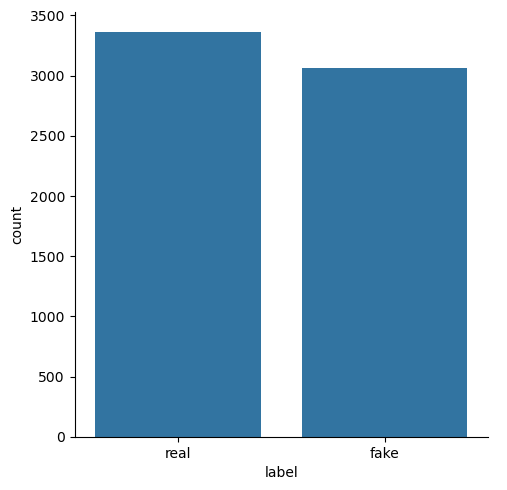

In [14]:
sns.catplot(data=df_train, kind='count', x='label')

#### Findings: Dataset is balanced. About 3000 per class in training set

<Axes: >

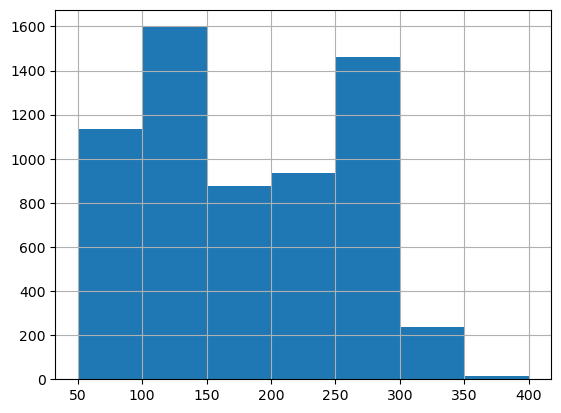

In [16]:
df_train['tweet'].str.len().hist(bins=[50,100,150,200,250,300,350,400])

#### Findings: Most messages have 100-150 or 250-300 words

In [18]:
def get_top_ngram(doc, n, c):
    vect = CountVectorizer(ngram_range=(n, n)).fit(doc)
    bag_of_words = vect.transform(doc)
    tot_words = bag_of_words.sum(axis=0)
    words_freq = [(word, tot_words[0, i])
                  for word, i in vect.vocabulary_.items()]
    return sorted(words_freq, key = lambda x: x[1], reverse=True)[:c]

<Axes: >

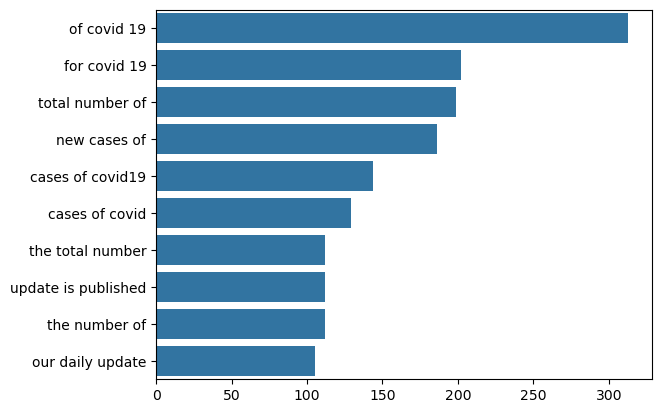

In [19]:
top_3_grams=get_top_ngram(df_train['tweet'],n=3, c=10)
x,y=map(list,zip(*top_3_grams))
sns.barplot(x=y,y=x)

#### Findings: 3 word combinations talk mostly about number of covid cases

<Axes: >

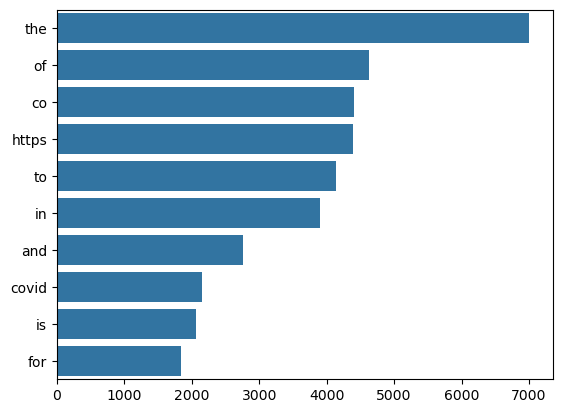

In [21]:
top_1_word=get_top_ngram(df_train['tweet'],n=1, c=10)
x,y=map(list,zip(*top_1_word))
sns.barplot(x=y,y=x)

#### Findings: 1000s of stop words across messages, that need to be removed

In [23]:
def plotWords():
    plt.figure(figsize = (10,10)) 
    wc = WordCloud(max_words = 500,background_color='gray', stopwords = STOPWORDS).generate(" ".join(df_train['tweet']))
    plt.imshow(wc , interpolation = 'bilinear')
    plt.axis("off")
    plt.show()

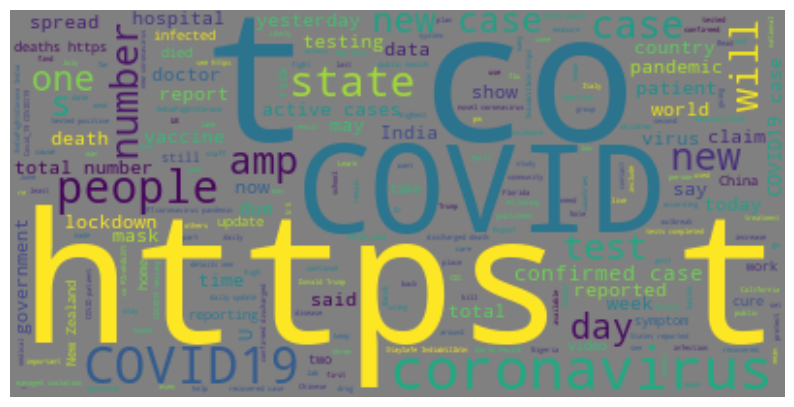

In [24]:
plotWords()

#### Findings: Word cloud shows lot of irrelevant words http, t.co 

### Data Preprocessing
> Remove usernames, http urls, punctuation, numerals.
> Lemmatize or word stem (Optional)

In [27]:
import re

In [28]:
def cleanTweet(text):
    text = text.lower()
    text = re.sub(r"@\w+", '', text)
    text = re.sub(r"http\S+", '', text)
    text = re.sub(r'[^\w\s]','',text)
    text = re.sub(r'[0-9]', '', text)
    #text = WordNetLemmatizer().lemmatize(text)
    #text = PorterStemmer().stem(text)
    return text

In [29]:
def tweetPreprocess(tweet):
    tweet =  ' '.join([cleanTweet(w) for w in TweetTokenizer().tokenize(tweet)])
    tweet =  ' '.join([word for word in tweet.split() if word not in stopwords.words('english')])
    return tweet

In [30]:
df_train['tweet'] = df_train['tweet'].apply(tweetPreprocess)
df_test['tweet'] = df_test['tweet'].apply(tweetPreprocess)

<Axes: >

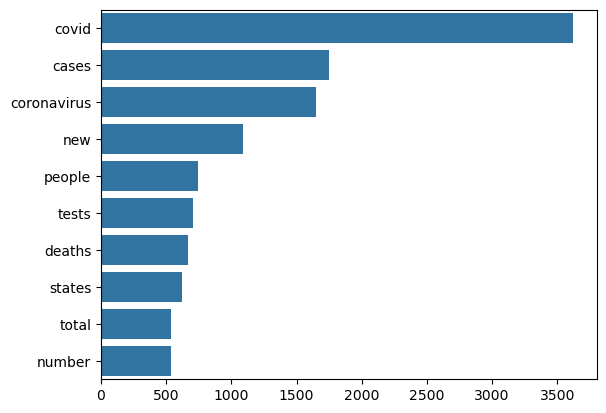

In [31]:
top_1_word=get_top_ngram(df_train['tweet'],n=1, c=10)
x,y=map(list,zip(*top_1_word))
sns.barplot(x=y,y=x)

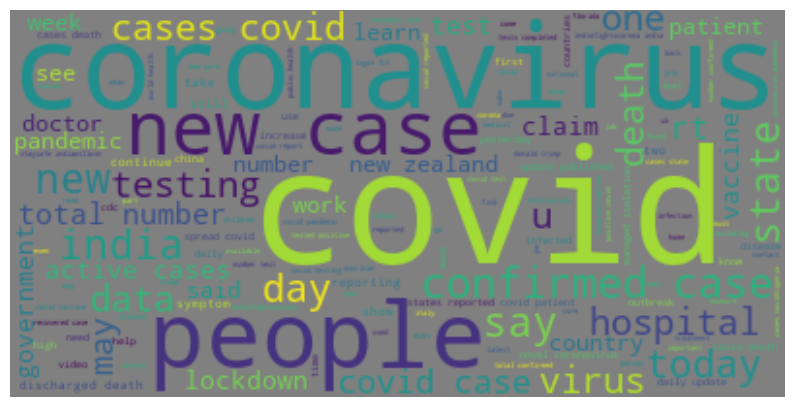

In [32]:
plotWords()

<Axes: >

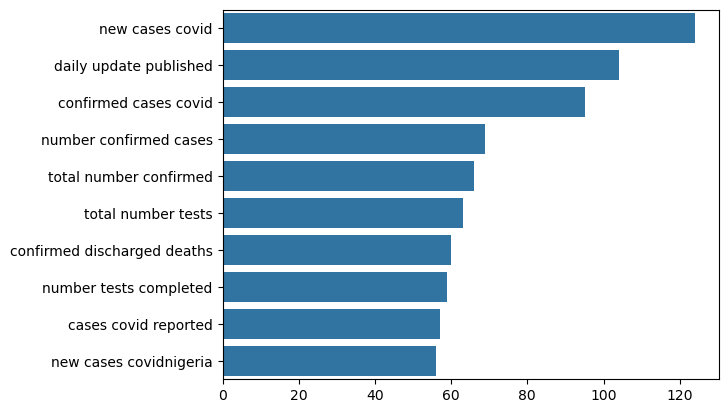

In [33]:
top_3_grams=get_top_ngram(df_train['tweet'],n=3, c=10)
x,y=map(list,zip(*top_3_grams))
sns.barplot(x=y,y=x)

#### Findings: Cleaning messages indicates relevant words to Covid-19 from word cloud, ngrams

### NLP Classifer Model Training and Evaulation
> Linear Regression, DecisionTree and MultinomialNB models are evaluated
> CountVectorizer and TDIDF text processing techniques are used
> Hyperparameters are set for each model and GridSearched for best model

In [36]:
X_train=df_train['tweet']
y_train=df_train['label']
X_test=df_test['tweet']
y_test=df_test['label']

In [37]:
X_train.head()

0    cdc currently reports deaths general discrepan...
1    states reported deaths small rise last tuesday...
2    politically correct woman almost uses pandemic...
3    indiafightscorona covid testing laboratories i...
4    populous states generate large case counts loo...
Name: tweet, dtype: object

In [38]:
y_test.head()

0    fake
1    fake
2    fake
3    fake
4    real
Name: label, dtype: object

In [39]:
res = pd.DataFrame(columns=['Train Accuracy', 'Test Accuracy', 'Execution Time(s)'])

In [40]:
vect_pipe = Pipeline([('cvect', CountVectorizer()),
                       ('lgr', LogisticRegression())])

In [41]:
lparams = {
                'lgr__penalty':['l2'],
                'lgr__C' : [1],
                'lgr__max_iter'  : [100, 200],
                'cvect__max_features': [5000, 10000, 20000],   
                'cvect__stop_words': ['english', None]
            }


In [42]:
s = time.time()
grid = GridSearchCV(vect_pipe, param_grid=lparams)
grid.fit(X_train, y_train)
e = time.time()
test_acc = grid.score(X_test, y_test)

In [43]:
train_acc = grid.score(X_train, y_train)
print(train_acc)
print(test_acc)
print(grid.best_params_)
print(e-s)
res.loc['LR with CV'] = [train_acc, test_acc, e-s]

0.9875389408099688
0.9210280373831776
{'cvect__max_features': 10000, 'cvect__stop_words': None, 'lgr__C': 1, 'lgr__max_iter': 100, 'lgr__penalty': 'l2'}
8.42617917060852


In [44]:
grid.best_params_

{'cvect__max_features': 10000,
 'cvect__stop_words': None,
 'lgr__C': 1,
 'lgr__max_iter': 100,
 'lgr__penalty': 'l2'}

In [45]:
y_pred = grid.predict(X_test)

In [46]:
def drawConfMat(conf, title):
    plt.figure(figsize=(6, 6))
    sns.heatmap(conf, annot=True, fmt="d", cbar=False)
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title(title)
    plt.show()

In [47]:
conf_lr = confusion_matrix(y_test, y_pred)

In [48]:
naive_pipe = Pipeline([('cvect', CountVectorizer()),
                       ('clf', MultinomialNB())])

In [49]:
tparams = {
        'cvect__max_features': [2000,5000,10000],
        'cvect__stop_words': [None],
        'clf__alpha': [1] 
}

In [50]:
s = time.time()
grid = GridSearchCV(naive_pipe, param_grid=tparams)
grid.fit(X_train, y_train)
e = time.time()
test_acc = grid.score(X_test, y_test)

In [51]:
train_acc = grid.score(X_train, y_train)
print(train_acc)
print(test_acc)
print(grid.best_params_)
print(e-s)
res.loc['MNB with CV'] = [train_acc, test_acc, e-s]

0.9478193146417445
0.9032710280373831
{'clf__alpha': 1, 'cvect__max_features': 10000, 'cvect__stop_words': None}
1.4072778224945068


In [52]:
y_pred = grid.predict(X_test)

In [53]:
conf_mnb = confusion_matrix(y_test, y_pred)

In [54]:
dparams = {
        'cvect__max_features': [2000,5000,10000],
        'cvect__stop_words': [None],
        'clf__max_depth': [100],
        'clf__min_samples_split': [2],
        'clf__min_samples_leaf': [2]
}

In [55]:
des_pipe = Pipeline([('cvect', CountVectorizer()),
                       ('clf', DecisionTreeClassifier())])

In [56]:
s = time.time()
grid = GridSearchCV(des_pipe, param_grid=dparams)
grid.fit(X_train, y_train)
e = time.time()
test_acc = grid.score(X_test, y_test)

In [57]:
train_acc = grid.score(X_train, y_train)
print(train_acc)
print(test_acc)
print(grid.best_params_)
print(e-s)
res.loc['DTree with CV'] = [train_acc, test_acc, e-s]

0.9473520249221183
0.8233644859813084
{'clf__max_depth': 100, 'clf__min_samples_leaf': 2, 'clf__min_samples_split': 2, 'cvect__max_features': 10000, 'cvect__stop_words': None}
5.5280070304870605


In [58]:
params = {
    'vect__max_df': (0.5, 0.75, 1.0),
    'vect__max_features': (5000, 10000, 50000),
    'vect__ngram_range': ((1, 1), (1, 2), (1,3))
    }

In [59]:
lparams = {
    'vect__max_df': (0.5, 0.75, 1.0),
    'vect__max_features': [5000],
    'vect__ngram_range': ((1, 1), (1, 2), (1,3)),    
    'lgr__penalty':['l2'],
    'lgr__C' : [1],
    'lgr__max_iter'  : [100, 200]
  }

In [60]:
tdf_pipe = Pipeline([('vect', TfidfVectorizer()),
                       ('lgr', LogisticRegression())])

In [61]:
s = time.time()
grid = GridSearchCV(tdf_pipe, param_grid=lparams)
grid.fit(X_train, y_train)
e = time.time()
test_acc = grid.score(X_test, y_test)

In [62]:
train_acc = grid.score(X_train, y_train)
print(train_acc)
print(test_acc)
print(grid.best_params_)
print(e-s)
res.loc['LR with TDIDF'] = [train_acc, test_acc, e-s]

0.9506230529595016
0.9088785046728972
{'lgr__C': 1, 'lgr__max_iter': 100, 'lgr__penalty': 'l2', 'vect__max_df': 0.5, 'vect__max_features': 5000, 'vect__ngram_range': (1, 2)}
20.984475135803223


In [63]:
dparams = {
    'vect__max_features': [5000],
    'vect__max_df': [0.5],
    'vect__ngram_range': [(1, 2), (1,3)], 
    'clf__max_depth': [50],
    'clf__min_samples_split': [2],
    'clf__min_samples_leaf': [2]
}

In [64]:
tdf_pipe1 = Pipeline([('vect', TfidfVectorizer()),
                        ('clf', DecisionTreeClassifier())])

In [65]:
s = time.time()
grid = GridSearchCV(tdf_pipe1, param_grid=dparams)
grid.fit(X_train, y_train)
e = time.time()
test_acc = grid.score(X_test, y_test)

In [66]:
train_acc = grid.score(X_train, y_train)
print(train_acc)
print(test_acc)
print(grid.best_params_)
print(e-s)
res.loc['DTree with TDIDF'] = [train_acc, test_acc, e-s]

0.9369158878504673
0.8313084112149532
{'clf__max_depth': 50, 'clf__min_samples_leaf': 2, 'clf__min_samples_split': 2, 'vect__max_df': 0.5, 'vect__max_features': 5000, 'vect__ngram_range': (1, 3)}
6.2723729610443115


In [67]:
mparams = {
    'vect__max_features': [50000], 
    'vect__max_df': [0.5],
    'vect__ngram_range': [(1, 2), (1,3)],    
    'clf__alpha': [1]
    }

In [68]:
tdf_pipe2 = Pipeline([('vect', TfidfVectorizer()),
                      ('clf', MultinomialNB())])

In [69]:
s = time.time()
grid = GridSearchCV(tdf_pipe2, param_grid=mparams)
grid.fit(X_train, y_train)
e = time.time()
test_acc = grid.score(X_test, y_test)

In [70]:
train_acc = grid.score(X_train, y_train)
print(train_acc)
print(test_acc)
print(grid.best_params_)
print(e-s)
res.loc['MNB with TDIDF'] = [train_acc, test_acc, e-s]

0.9809968847352025
0.9126168224299065
{'clf__alpha': 1, 'vect__max_df': 0.5, 'vect__max_features': 50000, 'vect__ngram_range': (1, 3)}
3.8371729850769043


In [71]:
y_pred = grid.predict(X_test)
conf_mnb1 = confusion_matrix(y_test, y_pred)

#### Findings: Results

In [73]:
print(res.sort_values('Test Accuracy', ascending=False))

                  Train Accuracy  Test Accuracy  Execution Time(s)
LR with CV              0.987539       0.921028           8.426179
MNB with TDIDF          0.980997       0.912617           3.837173
LR with TDIDF           0.950623       0.908879          20.984475
MNB with CV             0.947819       0.903271           1.407278
DTree with TDIDF        0.936916       0.831308           6.272373
DTree with CV           0.947352       0.823364           5.528007


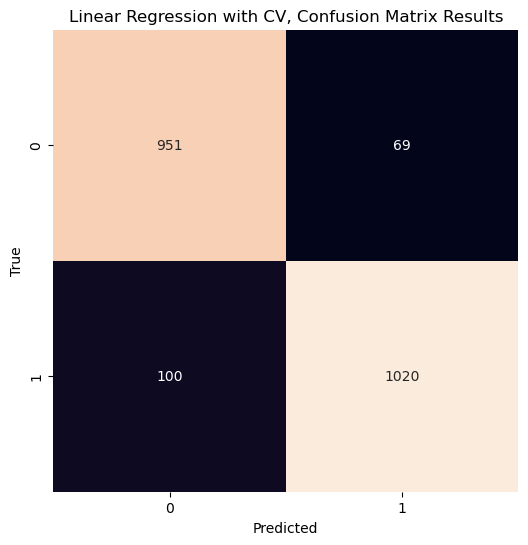

In [74]:
drawConfMat(conf_lr, "Linear Regression with CV, Confusion Matrix Results")

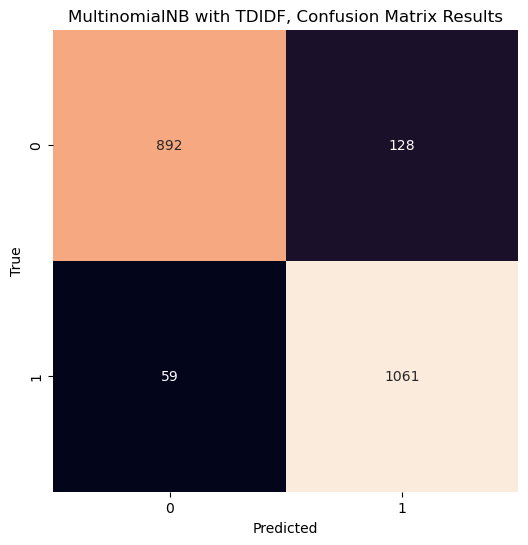

In [75]:
drawConfMat(conf_mnb1, "MultinomialNB with TDIDF, Confusion Matrix Results")

#### Findings: Conclusion
> Linear Regression with Count Vectorizer text processing technique produced the best model with accuracy of 92%

> Looking at confusion matrix LR classified 100 fake messages as facts, while MultinomialNB classifed 59 fake messages as true.

> Though MultiNomialNB had relatively lower accuracy, it has less false negatives,making it the chosen model.

> DecisionTree model had the least accuracy.
    
> ### Next steps

> Fine tune the model hyperparameters for Linear Regression and MultinomialNB to improve model accuracy and reduce false negatives.
